# Imports

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read data

In [66]:
data = pd.read_csv('../data/train.csv')
data_to_predict = pd.read_csv('../data/test.csv')
data_ccrisk = pd.read_csv('../data/credit_risk_dataset.csv')

data_ccrisk.dropna(inplace=True)
data_ccrisk.drop_duplicates(inplace=True)

X_old = data.drop(['loan_status'], axis=1)
y_old = data['loan_status']

# Merge the dataframes
data_no_id = data.drop(['id'], axis=1)
merged_data = pd.concat([data_no_id, data_ccrisk], ignore_index=True)

def remove_col_prefix(dataframe, prefix):
	dataframe.columns = dataframe.columns.str.replace(prefix, '')
	return dataframe

merged_data = remove_col_prefix(merged_data, 'person_')
merged_data = remove_col_prefix(merged_data, 'loan_')


print(merged_data.isnull().sum())
print(merged_data.duplicated().sum())

age                    0
income                 0
home_ownership         0
emp_length             0
intent                 0
grade                  0
amnt                   0
int_rate               0
percent_income         0
cb_default_on_file     0
cb_cred_hist_length    0
status                 0
dtype: int64
0


# Outliers

In [67]:
from scipy.stats import zscore

numeric_columns = merged_data.select_dtypes(include=[np.number]).columns

def remove_outiers(dataframe, numeric_cols, z_threshold=4):
	dataframe = dataframe[(np.abs(zscore(dataframe[numeric_cols])) < z_threshold).all(axis=1)].copy()
	return dataframe

data_no_outliers = remove_outiers(merged_data, numeric_columns)

In [68]:
merged_data.shape, data_no_outliers.shape

((87146, 12), (85518, 12))

# Feature engineering

## Feature Engineering Pipeline

In [69]:
# Create income bins before calling the function
income_bins = pd.qcut(data_no_outliers['income'], q=5, retbins=True)[1]

def feature_engineering(dataframe, income_bins):

    # Map grades to numerical values
    grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
    dataframe['grade_numeric'] = dataframe['grade'].map(grade_mapping)

    # Map cb_default_on_file to binary values
    dataframe['cb_default_on_file'] = dataframe['cb_default_on_file'].map({'Y': 1, 'N': 0})
    
    # Feature engineering
    dataframe['total_income'] = (dataframe['emp_length'] + 1) * dataframe['income']
    dataframe['emp_length_to_age_ratio'] = dataframe['emp_length'] / dataframe['age']
    dataframe['income_to_age_ratio'] = dataframe['income'] / dataframe['age']
    dataframe['total_income_to_age_ratio'] = dataframe['total_income'] / dataframe['age']
    dataframe['income_category'] = pd.cut(dataframe['income'], bins=income_bins, labels=[1, 2, 3, 4, 5])
    dataframe['income_to_loan_ratio'] = dataframe['income'] / dataframe['amnt']
    dataframe['total_income_to_loan_ratio'] = dataframe['total_income'] / dataframe['amnt']
    dataframe['loan_income_age_interaction'] = dataframe['amnt'] / (dataframe['income'] * dataframe['age'])
    dataframe['income_grade_interaction'] = dataframe['income'] * dataframe['grade_numeric']
    dataframe['loan_grade_ratio'] = dataframe['amnt'] / dataframe['grade_numeric']
    dataframe['emp_to_cred_hist_ratio'] = dataframe['emp_length'] / (dataframe['cb_cred_hist_length'] + 1)
    dataframe['credit_behavior_score'] = (1 - dataframe['cb_default_on_file']) * dataframe['cb_cred_hist_length']
    dataframe['affordability_score'] = dataframe['income'] / (dataframe['amnt'] * (1 + dataframe['int_rate']/100))
    dataframe['interest_cost'] = dataframe['amnt'] * dataframe['int_rate'] / 100 
    dataframe['emp_length_loan_interaction'] = dataframe['emp_length'] * dataframe['amnt']

    # Lists of numeric and ordinal features
    numeric = [
        'total_income', 'emp_length_to_age_ratio', 'income_to_age_ratio', 
        'total_income_to_age_ratio', 'income_to_loan_ratio', 
        'total_income_to_loan_ratio', 'loan_income_age_interaction', 
        'income_grade_interaction', 'loan_grade_ratio', 'emp_to_cred_hist_ratio', 
        'credit_behavior_score', 'affordability_score', 'interest_cost', 
        'emp_length_loan_interaction'
    ]
    ordinal = ['income_category']

    return dataframe, numeric, ordinal


In [70]:
data_no_outliers, new_features_numeric, new_features_ordinal = feature_engineering(data_no_outliers, income_bins)
X = data_no_outliers.drop(['status'], axis=1)
y = data_no_outliers['status']

X

,age,income,home_ownership,emp_length,intent,grade,amnt,int_rate,percent_income,cb_default_on_file,...,income_to_loan_ratio,total_income_to_loan_ratio,loan_income_age_interaction,income_grade_interaction,loan_grade_ratio,emp_to_cred_hist_ratio,credit_behavior_score,affordability_score,interest_cost,emp_length_loan_interaction
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,0,...,5.833333,5.833333,0.004633,70000,3000.000000,0.000000,14,5.232158,689.4,0.0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,0,...,14.000000,98.000000,0.003247,168000,1333.333333,2.000000,2,12.351125,534.0,24000.0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,0,...,4.800000,43.200000,0.007184,28800,6000.000000,0.727273,10,4.407713,534.0,48000.0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,0,...,5.833333,87.500000,0.005714,140000,6000.000000,2.333333,5,5.250053,1333.2,168000.0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,0,...,10.000000,30.000000,0.004545,60000,6000.000000,0.500000,3,9.352787,415.2,12000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87055,51,76960,MORTGAGE,0.0,PERSONAL,B,15000,9.99,0.19,0,...,5.130667,5.130667,0.003822,153920,7500.000000,0.000000,20,4.664666,1498.5,0.0
87122,51,80000,RENT,3.0,HOMEIMPROVEMENT,F,18000,18.78,0.23,1,...,4.444444,17.777778,0.004412,480000,3000.000000,0.142857,0,3.741745,3380.4,54000.0
87133,52,30000,RENT,6.0,VENTURE,C,5000,12.73,0.17,0,...,6.000000,42.000000,0.003205,90000,1666.666667,0.315789,18,5.322452,636.5,30000.0
87139,52,65004,RENT,4.0,PERSONAL,D,20000,15.58,0.31,1,...,3.250200,16.251000,0.005917,260016,5000.000000,0.200000,0,2.812078,3116.0,80000.0


In [71]:
all_data = feature_engineering(merged_data, income_bins)[0]

data_to_predict = remove_col_prefix(data_to_predict, 'person_')
data_to_predict = remove_col_prefix(data_to_predict, 'loan_')
data_to_predict = feature_engineering(data_to_predict, income_bins)[0]

In [72]:
column_names = all_data.columns
column_names

Index(['age', 'income', 'home_ownership', 'emp_length', 'intent', 'grade',
       'amnt', 'int_rate', 'percent_income', 'cb_default_on_file',
       'cb_cred_hist_length', 'status', 'grade_numeric', 'total_income',
       'emp_length_to_age_ratio', 'income_to_age_ratio',
       'total_income_to_age_ratio', 'income_category', 'income_to_loan_ratio',
       'total_income_to_loan_ratio', 'loan_income_age_interaction',
       'income_grade_interaction', 'loan_grade_ratio',
       'emp_to_cred_hist_ratio', 'credit_behavior_score',
       'affordability_score', 'interest_cost', 'emp_length_loan_interaction'],
      dtype='object')

In [73]:
X.dtypes

age                               int64
income                            int64
home_ownership                   object
emp_length                      float64
intent                           object
grade                            object
amnt                              int64
int_rate                        float64
percent_income                  float64
cb_default_on_file                int64
cb_cred_hist_length               int64
grade_numeric                     int64
total_income                    float64
emp_length_to_age_ratio         float64
income_to_age_ratio             float64
total_income_to_age_ratio       float64
income_category                category
income_to_loan_ratio            float64
total_income_to_loan_ratio      float64
loan_income_age_interaction     float64
income_grade_interaction          int64
loan_grade_ratio                float64
emp_to_cred_hist_ratio          float64
credit_behavior_score             int64
affordability_score             float64


# Preprocessing

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.2, random_state=2024)

In [76]:
onehot_cols = ['home_ownership', 'intent', 'cb_default_on_file']
ordinal_cols = ['grade', 'income_category']
standardize_cols = [
    'age', 'income', 'emp_length', 'amnt', 'int_rate', 'percent_income', 
    'cb_cred_hist_length', 'total_income', 'emp_length_to_age_ratio', 
    'income_to_age_ratio', 'total_income_to_age_ratio', 'income_to_loan_ratio', 
    'total_income_to_loan_ratio', 'loan_income_age_interaction', 
    'income_grade_interaction', 'loan_grade_ratio', 'emp_to_cred_hist_ratio', 
    'credit_behavior_score', 'affordability_score', 'interest_cost', 
    'emp_length_loan_interaction', 'grade_numeric'
]
log_transform_cols = ['income', 'total_income', 'amnt', 'interest_cost']

In [77]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer

def log_transform():
	return FunctionTransformer(np.log1p, validate=True)

# Imputers for missing values
ordinal_imputer = SimpleImputer(strategy='most_frequent')
onehot_imputer = SimpleImputer(strategy='most_frequent')
scaler_imputer = SimpleImputer(strategy='mean')
log_imputer = SimpleImputer(strategy='mean')

preprocessor = ColumnTransformer(
	transformers=[
		('ordinal', Pipeline([('imputer', ordinal_imputer), ('encoder', OrdinalEncoder())]), ordinal_cols),
		('onehot', Pipeline([('imputer', onehot_imputer), ('encoder', OneHotEncoder())]), onehot_cols),
		('scaler', Pipeline([('imputer', scaler_imputer), ('scaler', StandardScaler())]), standardize_cols),
		('log', Pipeline([('imputer', log_imputer), ('log', log_transform())]), log_transform_cols)
	], 
	remainder='passthrough',
	# force_int_remainder_cols=False
	)

preprocessor.fit(X_train)

X_train_prep = preprocessor.transform(X_train)
X_test_prep = preprocessor.transform(X_test)
data_prep = preprocessor.transform(all_data)
X_all_prep = preprocessor.transform(X)

In [78]:
standardize_cols_names = []
for name in standardize_cols:
	standardize_cols_names.append('std_' + name)

log_transform_cols_names = []
for name in log_transform_cols:
	log_transform_cols_names.append('log_' + name)

In [79]:
cols = preprocessor.transformers_[0][1]['encoder'].get_feature_names_out(ordinal_cols).tolist()
cols += preprocessor.transformers_[1][1]['encoder'].get_feature_names_out(onehot_cols).tolist()
cols += standardize_cols_names
cols += log_transform_cols_names

training_data_df = pd.DataFrame(X_train_prep, columns=cols)

In [80]:
training_plus_target = training_data_df.copy()
training_plus_target['status'] = y_train.values

In [81]:
training_plus_target.corr()['status'].sort_values(ascending=False)

status                             1.000000
grade                              0.390432
std_grade_numeric                  0.390432
std_percent_income                 0.380154
std_loan_income_age_interaction    0.363538
std_int_rate                       0.345783
std_interest_cost                  0.248579
home_ownership_RENT                0.235389
log_interest_cost                  0.220479
cb_default_on_file_1               0.186356
std_amnt                           0.133784
log_amnt                           0.105537
std_income_grade_interaction       0.096991
intent_DEBTCONSOLIDATION           0.062272
intent_MEDICAL                     0.050808
intent_HOMEIMPROVEMENT             0.031135
home_ownership_OTHER               0.003491
std_emp_length_loan_interaction   -0.002656
intent_PERSONAL                   -0.011013
std_cb_cred_hist_length           -0.013980
std_age                           -0.015303
intent_EDUCATION                  -0.056155
intent_VENTURE                  

In [82]:
# Shuffle columns with low correlation and recheck correlation

shuffled_col = training_plus_target['log_income'].copy()

permutation = np.random.permutation(shuffled_col.index)
shuffled_col = shuffled_col.reindex(permutation).reset_index(drop=True)

In [83]:
training_plus_target['control'] = shuffled_col

In [84]:
training_plus_target.corr()['status'].sort_values(ascending=False)

status                             1.000000
grade                              0.390432
std_grade_numeric                  0.390432
std_percent_income                 0.380154
std_loan_income_age_interaction    0.363538
std_int_rate                       0.345783
std_interest_cost                  0.248579
home_ownership_RENT                0.235389
log_interest_cost                  0.220479
cb_default_on_file_1               0.186356
std_amnt                           0.133784
log_amnt                           0.105537
std_income_grade_interaction       0.096991
intent_DEBTCONSOLIDATION           0.062272
intent_MEDICAL                     0.050808
intent_HOMEIMPROVEMENT             0.031135
control                            0.005151
home_ownership_OTHER               0.003491
std_emp_length_loan_interaction   -0.002656
intent_PERSONAL                   -0.011013
std_cb_cred_hist_length           -0.013980
std_age                           -0.015303
intent_EDUCATION                

# Models

In [85]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

In [86]:
dtrain = xgb.DMatrix(X_train_prep, label=y_train)
dtest = xgb.DMatrix(X_test_prep, label=y_test)

In [92]:
xgb_params = [
	{    
		'objective': 'binary:logistic',
		'learning_rate'         : 0.03, 
		'n_estimators'          : 5000,
		'max_depth'             : 7, 
		'colsample_bytree'      : 0.75, 
		'colsample_bynode'      : 0.85,
		'colsample_bylevel'     : 0.45,                     
		'reg_alpha'             : 0.001, 
		'reg_lambda'            : 0.25,
		'enable_categorical'    : True,
		'random_state'          : 42,
	},
	{
	'objective': 'binary:logistic',
	'eval_metric': 'auc',
	'n_estimators' : 5000,
	'max_depth': 7,
	'eta': 0.08,
	'reg_lambda': 38.5,
	'subsample': 0.88,
	'colsample_bytree': 0.65,
	'enable_categorical': True,
	'min_child_weight': 5,
	},
]

lgb_params = [
	{
		'objective': 'binary', 
		'metric':    'auc',
		'learning_rate'       : 0.0325, 
		'n_estimators'        : 5_000,
		'max_depth'           : 7, 
		'num_leaves'          : 25, 
		'min_data_in_leaf'    : 20,
		'feature_fraction'    : 0.70, 
		'bagging_fraction'    : 0.88, 
		'bagging_freq'        : 6, 
		'lambda_l1'           : 0.001, 
		'lambda_l2'           : 0.1,
		'verbosity': -1
	},
	{
		'objective': 'binary', 
		'metric':    'auc',
		'learning_rate'       : 0.035,
		'data_sample_strategy': 'goss', 
		'n_estimators'        : 5_000,
		'max_depth'           : 7, 
		'num_leaves'          : 30, 
		'min_data_in_leaf'    : 30,
		'feature_fraction'    : 0.60, 
		'colsample_bytree'    : 0.65,
		'lambda_l1'           : 0.001, 
		'lambda_l2'           : 1.25,
		'verbosity': -1 
	},
	{
		'objective': 'binary',
		'metric': 'auc',
		'max_depth': -1,
		'verbosity': -1,
		'n_estimators': 1500,
		'max_bin': 1024,
		'boosting_type': 'gbdt',
		'colsample_bytree': 0.57,        
		'eta': 0.055,
		'reg_lambda': 10.8,
		'min_child_samples': 70,
		'verbosity': -1
	},
]

cat_params = [
	{
		'task_type'           : "CPU",
		'loss_function'       : 'Logloss',
		'eval_metric'         : "AUC",
		'bagging_temperature' : 0.25,
		'colsample_bylevel'   : 0.40,
		'iterations'          : 5_000,
		'learning_rate'       : 0.045,
		'max_depth'           : 7,
		'l2_leaf_reg'         : 0.80,
		'min_data_in_leaf'    : 30,
		'random_strength'     : 0.25,
		'random_state': 42,
	},
	{
		'iterations': 1500,
		'depth': 6,
		'eta': 0.3, 
		'reg_lambda': 41.0, 
		'loss_function': 'Logloss',
		'eval_metric': 'AUC',
		'random_state': 42,
		'min_data_in_leaf': 51,
		'early_stopping_rounds': 150,
		'verbose':200,
	},
	{
		'iterations': 3000,
		'depth': 7,
		'eta': 0.3, 
		'reg_lambda': 40.0, 
		'loss_function': 'Logloss',
		'eval_metric': 'AUC',
		'random_state': 42,
		'min_data_in_leaf': 51,
		'early_stopping_rounds': 300,
		'verbose':200,
	},
	{
		'task_type'           : "CPU",
		'loss_function'       : 'Logloss',
		'eval_metric'         : "AUC",
		'bagging_temperature' : 0.25,
		'colsample_bylevel'   : 0.40,
		'iterations'          : 7_000,
		'learning_rate'       : 0.035,
		'max_depth'           : 8,
		'l2_leaf_reg'         : 0.80,
		'min_data_in_leaf'    : 30,
		'random_strength'     : 0.25,
		'early_stopping_rounds': 200,
		'random_state': 42,
	},
]

xgb_best_params = {
	'max_depth': 5, 
	'learning_rate': 0.15510732559366106, 
	'n_estimators': 234, 
	'subsample': 0.9898687238759246, 
	'colsample_bytree': 0.7464540470665002, 
	'gamma': 0.09187312187375563, 
	'lambda': 4.217578058395329e-08, 
	'alpha': 4.612413898803976, 
	'scale_pos_weight': 1.4354965045426993
	}

# AUC = 0.9560193210022325

lgb_best_params = {
	'learning_rate': 0.09719912894943394, 
	'num_leaves': 89, 
	'max_depth': 4, 
	'min_child_samples': 22, 
	'min_child_weight': 2.3600097912117226, 
	'subsample': 0.6540298281507695, 
	'colsample_bytree': 0.6037681533733157, 
	'n_estimators': 976, 
	'min_gain_to_split': 0.0055109231284258785,
	'verbosity': -1
	}

# AUC = 0.957831754193916

extratrees_best_params = {
	'n_estimators': 107, 
	'max_depth': 20, 
	'min_samples_split': 8, 
	'min_samples_leaf': 1, 
	'max_features': 0.9968259088694831}

# AUC = 0.9390769388981566

hist_best_params = {
	'learning_rate': 0.04424083488901783, 
	'max_iter': 249, 
	'max_depth': 12, 
	'min_samples_leaf': 28, 
	'max_leaf_nodes': 45, 
	'l2_regularization': 0.0024743098624130113
	}

# AUC = 0.9511768406476812

knn_best_params = {
	'n_neighbors': 15,
	'leaf_size': 41,
	'p': 1,
	'weights': 'distance'
	}

# AUC = 0.895272790005218

In [93]:
CAT7_params ={
    'learning_rate': 0.019914086642922255,
	'l2_leaf_reg': 0.5965527914059113,
	'bagging_temperature': 0.21414550710980085,
	'random_strength': 0.528432916293001,
	'depth': 5,
	'min_data_in_leaf': 132,
	'objective': 'Logloss',
	'eval_metric': "AUC",
	'verbose': 0,
	'n_estimators': 5000,

	}
CAT8_params = {
    'learning_rate': 0.09964585918770091,
	'l2_leaf_reg': 9.213583120085929,
	'bagging_temperature': 0.8971667774741543, 
	'random_strength': 1.3413807743378525,
	'depth': 7,
	'min_data_in_leaf': 64,
	'loss_function': 'Logloss',
	'eval_metric': "AUC",
	'n_estimators': 5000,
	}

CAT9_params = {
    'learning_rate': 0.029375245355338864,
	'l2_leaf_reg': 5.606401682614865,
	'bagging_temperature': 0.10279123124679676,
	'random_strength': 0.33545896157753763,
	'depth': 7,
	'min_data_in_leaf': 189,
	'loss_function': 'Logloss',
	'eval_metric': "AUC",
	'n_estimators': 5000,
	'grow_policy': 'SymmetricTree',
	'boosting_type': 'Plain',
}
CAT10_params = {
    'learning_rate': 0.05624354520782216,
	'l2_leaf_reg': 8.574301382348253,
	'bagging_temperature': 0.18124654280594427,
	'random_strength': 0.1134966757407917,
	'depth': 5,
	'min_data_in_leaf': 146,
	'loss_function': 'Logloss',
	'eval_metric': "AUC",
	'n_estimators': 5000,
	'grow_policy': 'SymmetricTree',
	'boosting_type': 'Plain',
    }

In [94]:
from sklearn.ensemble import ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

estimators ={
	'lgb1': lgb.LGBMClassifier(**lgb_params[1]),
	'lgb2': lgb.LGBMClassifier(**lgb_params[2]),
	'cat0': CatBoostClassifier(**cat_params[0]),
	'cat1': CatBoostClassifier(**cat_params[1]),
	'cat2': CatBoostClassifier(**cat_params[2]),
	'cat3': CatBoostClassifier(**cat_params[3]),
	'cat7': CatBoostClassifier(**CAT7_params),
	'cat8': CatBoostClassifier(**CAT8_params),
	'cat9': CatBoostClassifier(**CAT9_params),
	'cat10': CatBoostClassifier(**CAT10_params),
	'xgb0': xgb.XGBClassifier(**xgb_params[0]),
	'xgb1': xgb.XGBClassifier(**xgb_params[1]),
	'xgb_b': xgb.XGBClassifier(**xgb_best_params),
	'lgb_b': lgb.LGBMClassifier(**lgb_best_params),
	'extratrees': ExtraTreesClassifier(**extratrees_best_params),
	'hist': HistGradientBoostingClassifier(**hist_best_params),
	'knn': KNeighborsClassifier(**knn_best_params),
}

In [95]:
from tqdm import tqdm
for name, model in tqdm(estimators.items()):
	model.fit(X_train_prep, y_train)

0:	total: 184ms	remaining: 15m 19s
1:	total: 228ms	remaining: 9m 28s
2:	total: 275ms	remaining: 7m 38s
3:	total: 321ms	remaining: 6m 41s
4:	total: 361ms	remaining: 6m
5:	total: 413ms	remaining: 5m 43s
6:	total: 449ms	remaining: 5m 20s
7:	total: 479ms	remaining: 4m 59s
8:	total: 510ms	remaining: 4m 42s
9:	total: 544ms	remaining: 4m 31s
10:	total: 580ms	remaining: 4m 23s
11:	total: 612ms	remaining: 4m 14s
12:	total: 648ms	remaining: 4m 8s
13:	total: 679ms	remaining: 4m 1s
14:	total: 712ms	remaining: 3m 56s
15:	total: 746ms	remaining: 3m 52s
16:	total: 780ms	remaining: 3m 48s
17:	total: 815ms	remaining: 3m 45s
18:	total: 868ms	remaining: 3m 47s
19:	total: 915ms	remaining: 3m 47s
20:	total: 1.01s	remaining: 4m
21:	total: 1.05s	remaining: 3m 58s
22:	total: 1.09s	remaining: 3m 55s
23:	total: 1.12s	remaining: 3m 52s
24:	total: 1.16s	remaining: 3m 50s
25:	total: 1.19s	remaining: 3m 47s
26:	total: 1.23s	remaining: 3m 46s
27:	total: 1.27s	remaining: 3m 45s
28:	total: 1.31s	remaining: 3m 44s
29:	

0:	total: 33.4ms	remaining: 50.1s
200:	total: 6.04s	remaining: 39s
400:	total: 12s	remaining: 32.8s
600:	total: 18s	remaining: 27s
800:	total: 24.1s	remaining: 21.1s
1000:	total: 30.1s	remaining: 15s
1200:	total: 36.4s	remaining: 9.05s
1400:	total: 42.2s	remaining: 2.98s


1499:	total: 45.1s	remaining: 0us
0:	total: 94.5ms	remaining: 4m 43s
200:	total: 7.62s	remaining: 1m 46s
400:	total: 15s	remaining: 1m 37s
600:	total: 22.6s	remaining: 1m 30s
800:	total: 30.8s	remaining: 1m 24s
1000:	total: 38.4s	remaining: 1m 16s
1200:	total: 45.7s	remaining: 1m 8s
1400:	total: 54s	remaining: 1m 1s
1600:	total: 1m 1s	remaining: 53.6s
1800:	total: 1m 10s	remaining: 46.7s
2000:	total: 1m 18s	remaining: 39.1s
2200:	total: 1m 26s	remaining: 31.4s
2400:	total: 1m 35s	remaining: 23.8s
2600:	total: 1m 43s	remaining: 15.8s
2800:	total: 1m 50s	remaining: 7.86s


2999:	total: 1m 58s	remaining: 0us
0:	total: 119ms	remaining: 13m 49s
1:	total: 296ms	remaining: 17m 16s
2:	total: 470ms	remaining: 18m 16s
3:	total: 536ms	remaining: 15m 37s
4:	total: 592ms	remaining: 13m 48s
5:	total: 638ms	remaining: 12m 23s
6:	total: 688ms	remaining: 11m 27s
7:	total: 744ms	remaining: 10m 49s
8:	total: 805ms	remaining: 10m 25s
9:	total: 853ms	remaining: 9m 56s
10:	total: 897ms	remaining: 9m 30s
11:	total: 962ms	remaining: 9m 20s
12:	total: 1.02s	remaining: 9m 7s
13:	total: 1.07s	remaining: 8m 52s
14:	total: 1.11s	remaining: 8m 37s
15:	total: 1.17s	remaining: 8m 30s
16:	total: 1.23s	remaining: 8m 25s
17:	total: 1.27s	remaining: 8m 13s
18:	total: 1.32s	remaining: 8m 5s
19:	total: 1.38s	remaining: 8m
20:	total: 1.43s	remaining: 7m 56s
21:	total: 1.48s	remaining: 7m 49s
22:	total: 1.53s	remaining: 7m 43s
23:	total: 1.6s	remaining: 7m 44s
24:	total: 1.65s	remaining: 7m 39s
25:	total: 1.69s	remaining: 7m 33s
26:	total: 1.73s	remaining: 7m 28s
27:	total: 1.79s	remaining: 

0:	total: 34.6ms	remaining: 2m 52s
1:	total: 67.2ms	remaining: 2m 47s
2:	total: 100ms	remaining: 2m 47s
3:	total: 133ms	remaining: 2m 45s
4:	total: 165ms	remaining: 2m 45s
5:	total: 198ms	remaining: 2m 44s
6:	total: 231ms	remaining: 2m 44s
7:	total: 266ms	remaining: 2m 45s
8:	total: 305ms	remaining: 2m 49s
9:	total: 346ms	remaining: 2m 52s
10:	total: 384ms	remaining: 2m 54s
11:	total: 417ms	remaining: 2m 53s
12:	total: 448ms	remaining: 2m 51s
13:	total: 489ms	remaining: 2m 53s
14:	total: 523ms	remaining: 2m 53s
15:	total: 555ms	remaining: 2m 52s
16:	total: 587ms	remaining: 2m 51s
17:	total: 618ms	remaining: 2m 50s
18:	total: 650ms	remaining: 2m 50s
19:	total: 682ms	remaining: 2m 49s
20:	total: 718ms	remaining: 2m 50s
21:	total: 753ms	remaining: 2m 50s
22:	total: 785ms	remaining: 2m 49s
23:	total: 815ms	remaining: 2m 49s
24:	total: 850ms	remaining: 2m 49s
25:	total: 883ms	remaining: 2m 48s
26:	total: 915ms	remaining: 2m 48s
27:	total: 954ms	remaining: 2m 49s
28:	total: 989ms	remaining: 

0:	total: 37.5ms	remaining: 3m 7s
1:	total: 78.6ms	remaining: 3m 16s
2:	total: 114ms	remaining: 3m 9s
3:	total: 149ms	remaining: 3m 5s
4:	total: 185ms	remaining: 3m 4s
5:	total: 222ms	remaining: 3m 4s
6:	total: 263ms	remaining: 3m 7s
7:	total: 329ms	remaining: 3m 25s
8:	total: 381ms	remaining: 3m 31s
9:	total: 420ms	remaining: 3m 29s
10:	total: 455ms	remaining: 3m 26s
11:	total: 496ms	remaining: 3m 26s
12:	total: 553ms	remaining: 3m 32s
13:	total: 598ms	remaining: 3m 32s
14:	total: 641ms	remaining: 3m 32s
15:	total: 677ms	remaining: 3m 30s
16:	total: 715ms	remaining: 3m 29s
17:	total: 778ms	remaining: 3m 35s
18:	total: 888ms	remaining: 3m 52s
19:	total: 929ms	remaining: 3m 51s
20:	total: 976ms	remaining: 3m 51s
21:	total: 1.03s	remaining: 3m 53s
22:	total: 1.07s	remaining: 3m 52s
23:	total: 1.11s	remaining: 3m 50s
24:	total: 1.15s	remaining: 3m 49s
25:	total: 1.21s	remaining: 3m 51s
26:	total: 1.26s	remaining: 3m 52s
27:	total: 1.3s	remaining: 3m 50s
28:	total: 1.34s	remaining: 3m 49s


0:	total: 99.8ms	remaining: 8m 18s
1:	total: 129ms	remaining: 5m 21s
2:	total: 159ms	remaining: 4m 24s
3:	total: 181ms	remaining: 3m 46s
4:	total: 205ms	remaining: 3m 24s
5:	total: 232ms	remaining: 3m 12s
6:	total: 260ms	remaining: 3m 5s
7:	total: 282ms	remaining: 2m 55s
8:	total: 309ms	remaining: 2m 51s
9:	total: 350ms	remaining: 2m 54s
10:	total: 392ms	remaining: 2m 57s
11:	total: 431ms	remaining: 2m 59s
12:	total: 460ms	remaining: 2m 56s
13:	total: 482ms	remaining: 2m 51s
14:	total: 506ms	remaining: 2m 48s
15:	total: 538ms	remaining: 2m 47s
16:	total: 572ms	remaining: 2m 47s
17:	total: 608ms	remaining: 2m 48s
18:	total: 633ms	remaining: 2m 45s
19:	total: 662ms	remaining: 2m 44s
20:	total: 687ms	remaining: 2m 42s
21:	total: 709ms	remaining: 2m 40s
22:	total: 734ms	remaining: 2m 38s
23:	total: 762ms	remaining: 2m 37s
24:	total: 795ms	remaining: 2m 38s
25:	total: 838ms	remaining: 2m 40s
26:	total: 870ms	remaining: 2m 40s
27:	total: 905ms	remaining: 2m 40s
28:	total: 929ms	remaining: 2m

4998:	total: 2m 21s	remaining: 28.4ms
4999:	total: 2m 21s	remaining: 0us


100%|██████████| 17/17 [29:10<00:00, 102.95s/it]


In [97]:
predictions_train = []
predictions_test = []
for name, model in tqdm(estimators.items()):
	predictions_train.append((name, model.predict_proba(X_train_prep)[:, 1]))
	predictions_test.append((name, model.predict_proba(X_test_prep)[:, 1]))

100%|██████████| 17/17 [05:42<00:00, 20.12s/it]


In [100]:
from sklearn.metrics import roc_auc_score

aucs = []
for name, predictions in predictions_test:
	auc = roc_auc_score(y_test, predictions)
	aucs.append((name, auc))

aucs_df = pd.DataFrame(aucs, columns=['model', 'auc'])
aucs_df.sort_values(by='auc', ascending=False)

,model,auc
13,lgb_b,0.957417
9,cat10,0.956114
1,lgb2,0.955838
12,xgb_b,0.954604
8,cat9,0.954348
6,cat7,0.954053
0,lgb1,0.953689
2,cat0,0.952236
3,cat1,0.951797
10,xgb0,0.951245


In [180]:
best_models = aucs_df[aucs_df['auc'] > 0.954]
best_models_names = best_models['model'].tolist()

In [181]:
best_models_names

['lgb2', 'cat7', 'cat9', 'cat10', 'xgb_b', 'lgb_b']

In [182]:
preds_train_df = pd.DataFrame(dict(predictions_train), columns=[name for name in best_models_names])
preds_test_df = pd.DataFrame(dict(predictions_test), columns=[name for name in best_models_names])

In [183]:
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import roc_auc_score

In [184]:
from sklearn.linear_model import LogisticRegression

def objective_final_LogReg(trial):

	params = {
		'C': trial.suggest_float('C', 1e-5, 1e5, log=True),
		'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
		'n_jobs': -1,
		'random_state': 42
	}

	if params['penalty'] == 'l1':
		params['solver'] = 'liblinear'
	else:
		params['solver'] = 'lbfgs'

	model = LogisticRegression(**params)

	model.fit(preds_train_df, y_train)

	predictions = model.predict_proba(preds_test_df)[:, 1]
	auc = roc_auc_score(y_test, predictions)

	return auc

sampler = TPESampler(seed=42)
study_logreg = optuna.create_study(direction='maximize', sampler=sampler, study_name='final_LogReg')
study_logreg.optimize(objective_final_LogReg, n_trials=250, show_progress_bar=True, timeout=600)

[I 2024-11-01 00:33:58,724] A new study created in memory with name: final_LogReg


  0%|          | 0/250 [00:00<?, ?it/s]

c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
  0%|          | 0/17 [2:07:48<?, ?it/s]c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


[I 2024-11-01 00:33:59,306] Trial 0 finished with value: 0.9026055429056067 and parameters: {'C': 0.05564180225431373, 'penalty': 'l1'}. Best is trial 0 with value: 0.9026055429056067.


  0%|          | 0/17 [2:07:49<?, ?it/s]c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
  0%|          | 0/17 [2:07:49<?, ?it/s]

[I 2024-11-01 00:34:00,742] Trial 1 finished with value: 0.8660649400352812 and parameters: {'C': 9.695826644515218, 'penalty': 'l1'}. Best is trial 0 with value: 0.9026055429056067.
[I 2024-11-01 00:34:00,875] Trial 2 finished with value: 0.5 and parameters: {'C': 3.809220577048033e-05, 'penalty': 'l1'}. Best is trial 0 with value: 0.9026055429056067.


  0%|          | 0/17 [2:07:53<?, ?it/s]c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


[I 2024-11-01 00:34:04,018] Trial 3 finished with value: 0.8710241903661355 and parameters: {'C': 120.4275297251682, 'penalty': 'l2'}. Best is trial 0 with value: 0.9026055429056067.


  0%|          | 0/17 [2:07:54<?, ?it/s]

[I 2024-11-01 00:34:05,259] Trial 4 finished with value: 0.8653702820765325 and parameters: {'C': 2110.6995036049584, 'penalty': 'l1'}. Best is trial 0 with value: 0.9026055429056067.


  0%|          | 0/17 [2:07:55<?, ?it/s]

[I 2024-11-01 00:34:06,769] Trial 5 finished with value: 0.9583220077919724 and parameters: {'C': 0.0006824095540630409, 'penalty': 'l2'}. Best is trial 5 with value: 0.9583220077919724.


  0%|          | 0/17 [2:07:57<?, ?it/s]

[I 2024-11-01 00:34:08,328] Trial 6 finished with value: 0.9280853869077236 and parameters: {'C': 0.20866527711063718, 'penalty': 'l2'}. Best is trial 5 with value: 0.9583220077919724.


  0%|          | 0/17 [2:07:59<?, ?it/s]c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


[I 2024-11-01 00:34:10,228] Trial 7 finished with value: 0.9582961385226343 and parameters: {'C': 0.0002482782105195088, 'penalty': 'l2'}. Best is trial 5 with value: 0.9583220077919724.


  0%|          | 0/17 [2:07:59<?, ?it/s]c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


[I 2024-11-01 00:34:10,872] Trial 8 finished with value: 0.8786114613983467 and parameters: {'C': 0.36366360716958535, 'penalty': 'l1'}. Best is trial 5 with value: 0.9583220077919724.


  0%|          | 0/17 [2:08:00<?, ?it/s]

[I 2024-11-01 00:34:11,803] Trial 9 finished with value: 0.869921466344452 and parameters: {'C': 1.387855925997231, 'penalty': 'l1'}. Best is trial 5 with value: 0.9583220077919724.


  0%|          | 0/17 [2:08:02<?, ?it/s]

[I 2024-11-01 00:34:12,957] Trial 10 finished with value: 0.9583396087972349 and parameters: {'C': 0.00119175893378845, 'penalty': 'l2'}. Best is trial 10 with value: 0.9583396087972349.


  0%|          | 0/17 [2:08:03<?, ?it/s]

[I 2024-11-01 00:34:14,107] Trial 11 finished with value: 0.9583477285296204 and parameters: {'C': 0.0019962213812726574, 'penalty': 'l2'}. Best is trial 11 with value: 0.9583477285296204.


  0%|          | 0/17 [2:08:04<?, ?it/s]

[I 2024-11-01 00:34:15,251] Trial 12 finished with value: 0.958299554751504 and parameters: {'C': 0.0047723414009872836, 'penalty': 'l2'}. Best is trial 11 with value: 0.9583477285296204.


  0%|          | 0/17 [2:08:05<?, ?it/s]

[I 2024-11-01 00:34:16,450] Trial 13 finished with value: 0.9582790326230052 and parameters: {'C': 1.4320164160830557e-05, 'penalty': 'l2'}. Best is trial 11 with value: 0.9583477285296204.


  0%|          | 0/17 [2:08:06<?, ?it/s]

[I 2024-11-01 00:34:17,586] Trial 14 finished with value: 0.9582981437004491 and parameters: {'C': 0.00480524732521088, 'penalty': 'l2'}. Best is trial 11 with value: 0.9583477285296204.


  0%|          | 0/17 [2:08:07<?, ?it/s]

[I 2024-11-01 00:34:18,767] Trial 15 finished with value: 0.8648209128658645 and parameters: {'C': 47354.83674877203, 'penalty': 'l2'}. Best is trial 11 with value: 0.9583477285296204.


  0%|          | 0/17 [2:08:08<?, ?it/s]

[I 2024-11-01 00:34:19,885] Trial 16 finished with value: 0.9580623001320447 and parameters: {'C': 0.009674334254676786, 'penalty': 'l2'}. Best is trial 11 with value: 0.9583477285296204.


  0%|          | 0/17 [2:08:10<?, ?it/s]

[I 2024-11-01 00:34:20,995] Trial 17 finished with value: 0.9582982674768575 and parameters: {'C': 0.000260395263009312, 'penalty': 'l2'}. Best is trial 11 with value: 0.9583477285296204.


  0%|          | 0/17 [2:08:11<?, ?it/s]

[I 2024-11-01 00:34:22,161] Trial 18 finished with value: 0.8820843055970207 and parameters: {'C': 8.170834629191672, 'penalty': 'l2'}. Best is trial 11 with value: 0.9583477285296204.


  0%|          | 0/17 [2:08:12<?, ?it/s]

[I 2024-11-01 00:34:23,456] Trial 19 finished with value: 0.955595287782625 and parameters: {'C': 0.03063094453763608, 'penalty': 'l2'}. Best is trial 11 with value: 0.9583477285296204.


  0%|          | 0/17 [2:08:13<?, ?it/s]

[I 2024-11-01 00:34:24,722] Trial 20 finished with value: 0.9583466640525089 and parameters: {'C': 0.001608580216119328, 'penalty': 'l2'}. Best is trial 11 with value: 0.9583477285296204.


  0%|          | 0/17 [2:08:14<?, ?it/s]

[I 2024-11-01 00:34:25,877] Trial 21 finished with value: 0.9583466888077905 and parameters: {'C': 0.0014047340152265576, 'penalty': 'l2'}. Best is trial 11 with value: 0.9583477285296204.


  0%|          | 0/17 [2:08:16<?, ?it/s]

[I 2024-11-01 00:34:26,991] Trial 22 finished with value: 0.9582843797638444 and parameters: {'C': 6.58090803988944e-05, 'penalty': 'l2'}. Best is trial 11 with value: 0.9583477285296204.


  0%|          | 0/17 [2:08:17<?, ?it/s]

[I 2024-11-01 00:34:28,126] Trial 23 finished with value: 0.9583418615278663 and parameters: {'C': 0.001251969656165084, 'penalty': 'l2'}. Best is trial 11 with value: 0.9583477285296204.


  0%|          | 0/17 [2:08:18<?, ?it/s]

[I 2024-11-01 00:34:29,339] Trial 24 finished with value: 0.9481937556287322 and parameters: {'C': 0.07418890688776177, 'penalty': 'l2'}. Best is trial 11 with value: 0.9583477285296204.


  0%|          | 0/17 [2:08:19<?, ?it/s]

[I 2024-11-01 00:34:30,474] Trial 25 finished with value: 0.9582789336018787 and parameters: {'C': 1.1056091175536065e-05, 'penalty': 'l2'}. Best is trial 11 with value: 0.9583477285296204.


  0%|          | 0/17 [2:08:20<?, ?it/s]

[I 2024-11-01 00:34:31,592] Trial 26 finished with value: 0.9582892070437687 and parameters: {'C': 0.00010365611048427568, 'penalty': 'l2'}. Best is trial 11 with value: 0.9583477285296204.


  0%|          | 0/17 [2:08:21<?, ?it/s]

[I 2024-11-01 00:34:32,804] Trial 27 finished with value: 0.9579531293399104 and parameters: {'C': 0.011336340442292394, 'penalty': 'l2'}. Best is trial 11 with value: 0.9583477285296204.


  0%|          | 0/17 [2:08:23<?, ?it/s]c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


[I 2024-11-01 00:34:34,071] Trial 28 finished with value: 0.8916042957345165 and parameters: {'C': 2.412353335945475, 'penalty': 'l2'}. Best is trial 11 with value: 0.9583477285296204.


  0%|          | 0/17 [2:08:24<?, ?it/s]

[I 2024-11-01 00:34:34,988] Trial 29 finished with value: 0.90180300142937 and parameters: {'C': 0.05729023665976253, 'penalty': 'l1'}. Best is trial 11 with value: 0.9583477285296204.


  0%|          | 0/17 [2:08:25<?, ?it/s]

[I 2024-11-01 00:34:36,200] Trial 30 finished with value: 0.9583483969222252 and parameters: {'C': 0.0017568205560887448, 'penalty': 'l2'}. Best is trial 30 with value: 0.9583483969222252.


  0%|          | 0/17 [2:08:26<?, ?it/s]

[I 2024-11-01 00:34:37,370] Trial 31 finished with value: 0.9583501297919418 and parameters: {'C': 0.0018705422473945794, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:27<?, ?it/s]

[I 2024-11-01 00:34:38,510] Trial 32 finished with value: 0.9583063624539614 and parameters: {'C': 0.0003470049738043951, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:28<?, ?it/s]c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
                                        

[I 2024-11-01 00:34:39,725] Trial 33 finished with value: 0.9566387724152887 and parameters: {'C': 0.02379998819222213, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:28<?, ?it/s]

[I 2024-11-01 00:34:39,906] Trial 34 finished with value: 0.9558377410112334 and parameters: {'C': 0.0033178284094537297, 'penalty': 'l1'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:30<?, ?it/s]c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


[I 2024-11-01 00:34:41,082] Trial 35 finished with value: 0.9249866197702612 and parameters: {'C': 0.24516347458329224, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:31<?, ?it/s]

[I 2024-11-01 00:34:42,094] Trial 36 finished with value: 0.865498093595759 and parameters: {'C': 50.751797217397616, 'penalty': 'l1'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:32<?, ?it/s]

[I 2024-11-01 00:34:43,227] Trial 37 finished with value: 0.9582825478730015 and parameters: {'C': 4.659930936221797e-05, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:33<?, ?it/s]

[I 2024-11-01 00:34:44,356] Trial 38 finished with value: 0.9583128235824755 and parameters: {'C': 0.00045370379014932896, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:34<?, ?it/s]c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


[I 2024-11-01 00:34:45,587] Trial 39 finished with value: 0.9582892565543321 and parameters: {'C': 0.00010311053331231877, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:35<?, ?it/s]

[I 2024-11-01 00:34:46,339] Trial 40 finished with value: 0.8897271274812838 and parameters: {'C': 0.12132155607709343, 'penalty': 'l1'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:36<?, ?it/s]

[I 2024-11-01 00:34:47,478] Trial 41 finished with value: 0.958340549497938 and parameters: {'C': 0.0012300825923908735, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:37<?, ?it/s]

[I 2024-11-01 00:34:48,648] Trial 42 finished with value: 0.9577723662732063 and parameters: {'C': 0.013759454768351402, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:38<?, ?it/s]

[I 2024-11-01 00:34:49,799] Trial 43 finished with value: 0.958346589786664 and parameters: {'C': 0.0021636659816671134, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:40<?, ?it/s]

[I 2024-11-01 00:34:50,937] Trial 44 finished with value: 0.9583205224750726 and parameters: {'C': 0.0006434194435197204, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:41<?, ?it/s]

[I 2024-11-01 00:34:52,104] Trial 45 finished with value: 0.9583156209293033 and parameters: {'C': 0.004317192548261156, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:42<?, ?it/s]

[I 2024-11-01 00:34:53,288] Trial 46 finished with value: 0.9582959652356628 and parameters: {'C': 0.00021484417244274366, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:43<?, ?it/s]c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


[I 2024-11-01 00:34:54,469] Trial 47 finished with value: 0.9133485182231056 and parameters: {'C': 0.4525840309910518, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:44<?, ?it/s]

[I 2024-11-01 00:34:55,485] Trial 48 finished with value: 0.8653714703300524 and parameters: {'C': 1551.2213103061308, 'penalty': 'l1'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:45<?, ?it/s]

[I 2024-11-01 00:34:56,611] Trial 49 finished with value: 0.9582823003201848 and parameters: {'C': 3.4096609221134525e-05, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:46<?, ?it/s]

[I 2024-11-01 00:34:57,787] Trial 50 finished with value: 0.95817595163016 and parameters: {'C': 0.007688400144921405, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:48<?, ?it/s]

[I 2024-11-01 00:34:58,930] Trial 51 finished with value: 0.9583422823676545 and parameters: {'C': 0.0027490362252746182, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:49<?, ?it/s]

[I 2024-11-01 00:35:00,100] Trial 52 finished with value: 0.9558641548967681 and parameters: {'C': 0.028960099200799363, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:50<?, ?it/s]

[I 2024-11-01 00:35:01,275] Trial 53 finished with value: 0.9583360935472387 and parameters: {'C': 0.0010279739064036903, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:51<?, ?it/s]

[I 2024-11-01 00:35:02,427] Trial 54 finished with value: 0.9583492881123652 and parameters: {'C': 0.0019279540352388368, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:53<?, ?it/s]

[I 2024-11-01 00:35:03,981] Trial 55 finished with value: 0.9582918063483433 and parameters: {'C': 0.0001675732345836173, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:54<?, ?it/s]

[I 2024-11-01 00:35:05,126] Trial 56 finished with value: 0.9583147544944451 and parameters: {'C': 0.00051132542518959, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:55<?, ?it/s]

[I 2024-11-01 00:35:06,275] Trial 57 finished with value: 0.9583463174785656 and parameters: {'C': 0.001387449782172007, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:56<?, ?it/s]

[I 2024-11-01 00:35:07,422] Trial 58 finished with value: 0.9582822508096214 and parameters: {'C': 3.188797447169201e-05, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:57<?, ?it/s]

[I 2024-11-01 00:35:08,578] Trial 59 finished with value: 0.9580352426091869 and parameters: {'C': 0.010090531093052954, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:58<?, ?it/s]

[I 2024-11-01 00:35:09,747] Trial 60 finished with value: 0.9582867067603208 and parameters: {'C': 0.005242697600003418, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:08:59<?, ?it/s]

[I 2024-11-01 00:35:10,903] Trial 61 finished with value: 0.9583428517391328 and parameters: {'C': 0.002680419336882965, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:01<?, ?it/s]

[I 2024-11-01 00:35:12,088] Trial 62 finished with value: 0.9583467878289171 and parameters: {'C': 0.0020689958198626857, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:02<?, ?it/s]

[I 2024-11-01 00:35:13,253] Trial 63 finished with value: 0.955722406153965 and parameters: {'C': 0.02987936460095332, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:03<?, ?it/s]

[I 2024-11-01 00:35:14,397] Trial 64 finished with value: 0.9583229980032391 and parameters: {'C': 0.0007676192031512245, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:04<?, ?it/s]c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
  0%|          | 0/17 [2:09:04<?, ?it/s]

[I 2024-11-01 00:35:15,547] Trial 65 finished with value: 0.9583463422338472 and parameters: {'C': 0.0016180609859473257, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.
[I 2024-11-01 00:35:15,708] Trial 66 finished with value: 0.9558377410112334 and parameters: {'C': 0.0002486576513268515, 'penalty': 'l1'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:06<?, ?it/s]

[I 2024-11-01 00:35:16,922] Trial 67 finished with value: 0.957364919092313 and parameters: {'C': 0.017994473972985058, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:07<?, ?it/s]

[I 2024-11-01 00:35:18,164] Trial 68 finished with value: 0.9582608374909828 and parameters: {'C': 0.005897157976206932, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:08<?, ?it/s]

[I 2024-11-01 00:35:19,385] Trial 69 finished with value: 0.9582898011705288 and parameters: {'C': 0.00011518767993253986, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:09<?, ?it/s]

[I 2024-11-01 00:35:20,614] Trial 70 finished with value: 0.8648194027936831 and parameters: {'C': 64435.892648217196, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:10<?, ?it/s]

[I 2024-11-01 00:35:21,855] Trial 71 finished with value: 0.9583476295084937 and parameters: {'C': 0.0020403967001889713, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:12<?, ?it/s]

[I 2024-11-01 00:35:23,050] Trial 72 finished with value: 0.9583059911247365 and parameters: {'C': 0.0003701789939127561, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:13<?, ?it/s]

[I 2024-11-01 00:35:24,187] Trial 73 finished with value: 0.9583449311827924 and parameters: {'C': 0.002343032867500585, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:14<?, ?it/s]

[I 2024-11-01 00:35:25,337] Trial 74 finished with value: 0.9583226019187325 and parameters: {'C': 0.0007072153249285127, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:15<?, ?it/s]

[I 2024-11-01 00:35:26,718] Trial 75 finished with value: 0.9508212564691743 and parameters: {'C': 0.06011625039322025, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:17<?, ?it/s]c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


[I 2024-11-01 00:35:27,913] Trial 76 finished with value: 0.9582798990578635 and parameters: {'C': 1.997972936737008e-05, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:17<?, ?it/s]

[I 2024-11-01 00:35:28,489] Trial 77 finished with value: 0.888468692737939 and parameters: {'C': 0.1388715916142337, 'penalty': 'l1'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:18<?, ?it/s]

[I 2024-11-01 00:35:29,618] Trial 78 finished with value: 0.9582862364099693 and parameters: {'C': 7.456037166723246e-05, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:19<?, ?it/s]

[I 2024-11-01 00:35:30,780] Trial 79 finished with value: 0.9581113155897376 and parameters: {'C': 0.008800448599477219, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:21<?, ?it/s]

[I 2024-11-01 00:35:31,928] Trial 80 finished with value: 0.9583398068394883 and parameters: {'C': 0.0012121564239139502, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:22<?, ?it/s]

[I 2024-11-01 00:35:33,147] Trial 81 finished with value: 0.9583431735577944 and parameters: {'C': 0.0024218944008165505, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:23<?, ?it/s]

[I 2024-11-01 00:35:34,329] Trial 82 finished with value: 0.9583165368747248 and parameters: {'C': 0.004275674215212176, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:24<?, ?it/s]

[I 2024-11-01 00:35:35,479] Trial 83 finished with value: 0.95835010503666 and parameters: {'C': 0.001863244730504411, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:25<?, ?it/s]

[I 2024-11-01 00:35:36,633] Trial 84 finished with value: 0.9583071051124112 and parameters: {'C': 0.0003804774072995065, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:26<?, ?it/s]

[I 2024-11-01 00:35:37,851] Trial 85 finished with value: 0.9574256437982326 and parameters: {'C': 0.017461675187287567, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:28<?, ?it/s]

[I 2024-11-01 00:35:39,016] Trial 86 finished with value: 0.9583466392972272 and parameters: {'C': 0.0016311785363593537, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:29<?, ?it/s]c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
  0%|          | 0/17 [2:09:29<?, ?it/s]

[I 2024-11-01 00:35:40,147] Trial 87 finished with value: 0.958321314644086 and parameters: {'C': 0.0006780956160301099, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.
[I 2024-11-01 00:35:40,303] Trial 88 finished with value: 0.9558377410112334 and parameters: {'C': 0.00015848634625139127, 'penalty': 'l1'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:30<?, ?it/s]

[I 2024-11-01 00:35:41,495] Trial 89 finished with value: 0.9583205967409175 and parameters: {'C': 0.004047919022440982, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:31<?, ?it/s]

[I 2024-11-01 00:35:42,883] Trial 90 finished with value: 0.8648453463288659 and parameters: {'C': 9345.298257152941, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:33<?, ?it/s]

[I 2024-11-01 00:35:44,165] Trial 91 finished with value: 0.958346144191594 and parameters: {'C': 0.0015344514849413736, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:34<?, ?it/s]

[I 2024-11-01 00:35:45,448] Trial 92 finished with value: 0.9581577069875744 and parameters: {'C': 0.008027870724928573, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:35<?, ?it/s]

[I 2024-11-01 00:35:46,703] Trial 93 finished with value: 0.9583486939856052 and parameters: {'C': 0.0019764783473171844, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:37<?, ?it/s]

[I 2024-11-01 00:35:47,916] Trial 94 finished with value: 0.9583227504504223 and parameters: {'C': 0.0007096331869405119, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:38<?, ?it/s]

[I 2024-11-01 00:35:49,082] Trial 95 finished with value: 0.9583399058606148 and parameters: {'C': 0.0029819774152970726, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:39<?, ?it/s]

[I 2024-11-01 00:35:50,251] Trial 96 finished with value: 0.8850344420233779 and parameters: {'C': 5.005574590316316, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:40<?, ?it/s]

[I 2024-11-01 00:35:51,461] Trial 97 finished with value: 0.8709104646021752 and parameters: {'C': 152.78013403294906, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:41<?, ?it/s]

[I 2024-11-01 00:35:52,652] Trial 98 finished with value: 0.9531386726515034 and parameters: {'C': 0.04282788349481882, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:42<?, ?it/s]

[I 2024-11-01 00:35:53,800] Trial 99 finished with value: 0.9583039364363585 and parameters: {'C': 0.000312360827398507, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:44<?, ?it/s]

[I 2024-11-01 00:35:54,950] Trial 100 finished with value: 0.9583271816458401 and parameters: {'C': 0.0008434805510027605, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:45<?, ?it/s]

[I 2024-11-01 00:35:56,145] Trial 101 finished with value: 0.9583496099310267 and parameters: {'C': 0.0017906919329925774, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:46<?, ?it/s]

[I 2024-11-01 00:35:57,319] Trial 102 finished with value: 0.9583117095948007 and parameters: {'C': 0.0044363780981457246, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:47<?, ?it/s]

[I 2024-11-01 00:35:58,507] Trial 103 finished with value: 0.9578283874756099 and parameters: {'C': 0.01312719795749884, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:48<?, ?it/s]

[I 2024-11-01 00:35:59,664] Trial 104 finished with value: 0.9583483226563803 and parameters: {'C': 0.001992231458206889, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:49<?, ?it/s]

[I 2024-11-01 00:36:00,848] Trial 105 finished with value: 0.9582535594381739 and parameters: {'C': 0.006036164530407255, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:51<?, ?it/s]

[I 2024-11-01 00:36:02,001] Trial 106 finished with value: 0.9583500060155333 and parameters: {'C': 0.0019507410295240704, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:52<?, ?it/s]

[I 2024-11-01 00:36:03,144] Trial 107 finished with value: 0.9583129721141654 and parameters: {'C': 0.0004565871441712776, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:53<?, ?it/s]c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
  0%|          | 0/17 [2:09:53<?, ?it/s]

[I 2024-11-01 00:36:04,299] Trial 108 finished with value: 0.9583367866951255 and parameters: {'C': 0.0010890927940871004, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.
[I 2024-11-01 00:36:04,475] Trial 109 finished with value: 0.9558377410112334 and parameters: {'C': 0.0017547605416110192, 'penalty': 'l1'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:54<?, ?it/s]

[I 2024-11-01 00:36:05,827] Trial 110 finished with value: 0.9583407722954731 and parameters: {'C': 0.002876594527033401, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:56<?, ?it/s]

[I 2024-11-01 00:36:07,238] Trial 111 finished with value: 0.9582242491846849 and parameters: {'C': 0.006750453819946674, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:57<?, ?it/s]

[I 2024-11-01 00:36:08,436] Trial 112 finished with value: 0.9583342616563957 and parameters: {'C': 0.0010040314032645167, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:58<?, ?it/s]

[I 2024-11-01 00:36:09,577] Trial 113 finished with value: 0.9582961137673528 and parameters: {'C': 0.00020889420263990173, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:09:59<?, ?it/s]

[I 2024-11-01 00:36:10,777] Trial 114 finished with value: 0.9583252507338703 and parameters: {'C': 0.003916441867234896, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:10:01<?, ?it/s]

[I 2024-11-01 00:36:11,929] Trial 115 finished with value: 0.9583467135630722 and parameters: {'C': 0.002145666866408167, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:10:02<?, ?it/s]

[I 2024-11-01 00:36:13,083] Trial 116 finished with value: 0.958346218457439 and parameters: {'C': 0.0021776527680883164, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:10:03<?, ?it/s]

[I 2024-11-01 00:36:14,232] Trial 117 finished with value: 0.9583148040050083 and parameters: {'C': 0.0005144443371065844, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:10:04<?, ?it/s]

[I 2024-11-01 00:36:15,395] Trial 118 finished with value: 0.9580861642235678 and parameters: {'C': 0.009239221672430417, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:10:05<?, ?it/s]

[I 2024-11-01 00:36:16,554] Trial 119 finished with value: 0.9583471839134239 and parameters: {'C': 0.0020359529671571948, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:10:06<?, ?it/s]

[I 2024-11-01 00:36:17,748] Trial 120 finished with value: 0.957260055719188 and parameters: {'C': 0.01907683342253004, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:10:08<?, ?it/s]

[I 2024-11-01 00:36:18,908] Trial 121 finished with value: 0.9583480998588454 and parameters: {'C': 0.0017190478335653032, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:10:09<?, ?it/s]

[I 2024-11-01 00:36:20,099] Trial 122 finished with value: 0.9583361925683652 and parameters: {'C': 0.0010307064144935345, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:10:10<?, ?it/s]

[I 2024-11-01 00:36:21,259] Trial 123 finished with value: 0.9583394850208266 and parameters: {'C': 0.0030935123088538783, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:10:11<?, ?it/s]

[I 2024-11-01 00:36:22,409] Trial 124 finished with value: 0.9583469858711706 and parameters: {'C': 0.001597893399639437, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:10:12<?, ?it/s]

[I 2024-11-01 00:36:23,554] Trial 125 finished with value: 0.9583221315683809 and parameters: {'C': 0.0006839861340612339, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:10:13<?, ?it/s]

[I 2024-11-01 00:36:24,760] Trial 126 finished with value: 0.9583092588219159 and parameters: {'C': 0.0004093837907740874, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:10:15<?, ?it/s]

[I 2024-11-01 00:36:25,920] Trial 127 finished with value: 0.9583467383183539 and parameters: {'C': 0.0015202702522253977, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:10:16<?, ?it/s]c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


[I 2024-11-01 00:36:27,082] Trial 128 finished with value: 0.9582848253589146 and parameters: {'C': 0.005299205488659391, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:10:16<?, ?it/s]

[I 2024-11-01 00:36:27,312] Trial 129 finished with value: 0.9455086987584236 and parameters: {'C': 0.012867816922471931, 'penalty': 'l1'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:10:17<?, ?it/s]

[I 2024-11-01 00:36:28,517] Trial 130 finished with value: 0.9583383215225885 and parameters: {'C': 0.0011462933915327971, 'penalty': 'l2'}. Best is trial 31 with value: 0.9583501297919418.


  0%|          | 0/17 [2:10:18<?, ?it/s]

[I 2024-11-01 00:36:29,700] Trial 131 finished with value: 0.9583506248975749 and parameters: {'C': 0.0018571809438969167, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:19<?, ?it/s]

[I 2024-11-01 00:36:30,880] Trial 132 finished with value: 0.9583372075349136 and parameters: {'C': 0.0033679070610619787, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:21<?, ?it/s]

[I 2024-11-01 00:36:32,052] Trial 133 finished with value: 0.958243706836072 and parameters: {'C': 0.006215574026745508, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:22<?, ?it/s]

[I 2024-11-01 00:36:33,228] Trial 134 finished with value: 0.9066196365825632 and parameters: {'C': 0.7074725947928544, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:23<?, ?it/s]

[I 2024-11-01 00:36:34,386] Trial 135 finished with value: 0.958348198879972 and parameters: {'C': 0.0019940819551133963, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:24<?, ?it/s]

[I 2024-11-01 00:36:35,577] Trial 136 finished with value: 0.9583275777303466 and parameters: {'C': 0.0008335013352112538, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:25<?, ?it/s]

[I 2024-11-01 00:36:36,742] Trial 137 finished with value: 0.9583473324451138 and parameters: {'C': 0.002107895788348461, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:26<?, ?it/s]

[I 2024-11-01 00:36:37,888] Trial 138 finished with value: 0.9583020797902337 and parameters: {'C': 0.0002846539301978345, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:28<?, ?it/s]

[I 2024-11-01 00:36:39,059] Trial 139 finished with value: 0.9583310929803428 and parameters: {'C': 0.0036271341120109168, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:29<?, ?it/s]

[I 2024-11-01 00:36:40,202] Trial 140 finished with value: 0.9583174528201464 and parameters: {'C': 0.0005575893762944766, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:30<?, ?it/s]

[I 2024-11-01 00:36:41,398] Trial 141 finished with value: 0.9583502040577868 and parameters: {'C': 0.0018357259280473526, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:31<?, ?it/s]

[I 2024-11-01 00:36:42,557] Trial 142 finished with value: 0.9583447331405391 and parameters: {'C': 0.0023468315460011707, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:32<?, ?it/s]

[I 2024-11-01 00:36:43,718] Trial 143 finished with value: 0.9583375293535752 and parameters: {'C': 0.0010981357363192632, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:33<?, ?it/s]

[I 2024-11-01 00:36:44,886] Trial 144 finished with value: 0.9581096569858663 and parameters: {'C': 0.008821832299042131, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:35<?, ?it/s]

[I 2024-11-01 00:36:46,041] Trial 145 finished with value: 0.9583260181476019 and parameters: {'C': 0.003887192948735584, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:36<?, ?it/s]

[I 2024-11-01 00:36:47,234] Trial 146 finished with value: 0.9583470106264522 and parameters: {'C': 0.001509125303447486, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:37<?, ?it/s]

[I 2024-11-01 00:36:48,395] Trial 147 finished with value: 0.9583175023307097 and parameters: {'C': 0.0005616169966651069, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:38<?, ?it/s]

[I 2024-11-01 00:36:49,550] Trial 148 finished with value: 0.9583433220894844 and parameters: {'C': 0.002645044336474334, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:39<?, ?it/s]c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
  0%|          | 0/17 [2:10:39<?, ?it/s]

[I 2024-11-01 00:36:50,715] Trial 149 finished with value: 0.9582357851459399 and parameters: {'C': 0.006484219607401344, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.
[I 2024-11-01 00:36:50,840] Trial 150 finished with value: 0.5 and parameters: {'C': 0.00014290602893714743, 'penalty': 'l1'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:41<?, ?it/s]

[I 2024-11-01 00:36:52,005] Trial 151 finished with value: 0.9583489415384219 and parameters: {'C': 0.001914361311637948, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:42<?, ?it/s]

[I 2024-11-01 00:36:53,376] Trial 152 finished with value: 0.9583278747937265 and parameters: {'C': 0.0009032848349642684, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:43<?, ?it/s]

[I 2024-11-01 00:36:54,711] Trial 153 finished with value: 0.958347753284902 and parameters: {'C': 0.0017210252153385642, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:45<?, ?it/s]

[I 2024-11-01 00:36:56,070] Trial 154 finished with value: 0.9583429260049778 and parameters: {'C': 0.0012776742591635813, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:46<?, ?it/s]

[I 2024-11-01 00:36:57,433] Trial 155 finished with value: 0.958300643983897 and parameters: {'C': 0.004761522483417498, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:47<?, ?it/s]

[I 2024-11-01 00:36:58,779] Trial 156 finished with value: 0.95833968306308 and parameters: {'C': 0.003076730578261321, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:49<?, ?it/s]

[I 2024-11-01 00:37:00,103] Trial 157 finished with value: 0.9583501297919417 and parameters: {'C': 0.0018086329539786688, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:50<?, ?it/s]

[I 2024-11-01 00:37:01,549] Trial 158 finished with value: 0.8698853731437871 and parameters: {'C': 32.570805272677624, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:51<?, ?it/s]

[I 2024-11-01 00:37:02,763] Trial 159 finished with value: 0.9583223791211974 and parameters: {'C': 0.0007565259069301686, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:53<?, ?it/s]

[I 2024-11-01 00:37:03,909] Trial 160 finished with value: 0.958305867348328 and parameters: {'C': 0.000338499576963504, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:54<?, ?it/s]

[I 2024-11-01 00:37:05,066] Trial 161 finished with value: 0.9583474809768038 and parameters: {'C': 0.0017220676852961996, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:55<?, ?it/s]

[I 2024-11-01 00:37:06,221] Trial 162 finished with value: 0.9583397078183615 and parameters: {'C': 0.0011951857902532757, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:56<?, ?it/s]

[I 2024-11-01 00:37:07,385] Trial 163 finished with value: 0.9583478770613103 and parameters: {'C': 0.0021203709730289568, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:57<?, ?it/s]

[I 2024-11-01 00:37:08,591] Trial 164 finished with value: 0.9583351528465354 and parameters: {'C': 0.0034402655477777156, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:58<?, ?it/s]

[I 2024-11-01 00:37:09,749] Trial 165 finished with value: 0.9582731408659695 and parameters: {'C': 0.005559977901928361, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:10:59<?, ?it/s]

[I 2024-11-01 00:37:10,895] Trial 166 finished with value: 0.9583480255930003 and parameters: {'C': 0.0017173549646891174, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:01<?, ?it/s]

[I 2024-11-01 00:37:12,052] Trial 167 finished with value: 0.9583153486212052 and parameters: {'C': 0.0005246067738355369, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:02<?, ?it/s]

[I 2024-11-01 00:37:13,208] Trial 168 finished with value: 0.9583503278341952 and parameters: {'C': 0.0018601897665778372, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:03<?, ?it/s]

[I 2024-11-01 00:37:14,400] Trial 169 finished with value: 0.9583244090542936 and parameters: {'C': 0.0008082836308025834, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:04<?, ?it/s]

[I 2024-11-01 00:37:15,581] Trial 170 finished with value: 0.9579409249860503 and parameters: {'C': 0.01151619918122464, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:05<?, ?it/s]

[I 2024-11-01 00:37:16,752] Trial 171 finished with value: 0.9583502783236317 and parameters: {'C': 0.001852623617524609, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:07<?, ?it/s]

[I 2024-11-01 00:37:17,919] Trial 172 finished with value: 0.9583422823676544 and parameters: {'C': 0.0027499505322043714, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:08<?, ?it/s]

[I 2024-11-01 00:37:19,075] Trial 173 finished with value: 0.9583383215225885 and parameters: {'C': 0.0011560423443792661, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:09<?, ?it/s]

[I 2024-11-01 00:37:20,308] Trial 174 finished with value: 0.9583482483905355 and parameters: {'C': 0.001991077982280348, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:10<?, ?it/s]

[I 2024-11-01 00:37:21,544] Trial 175 finished with value: 0.958320794783171 and parameters: {'C': 0.004067670636448174, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:11<?, ?it/s]

[I 2024-11-01 00:37:22,828] Trial 176 finished with value: 0.9583463422338473 and parameters: {'C': 0.0013953903414556706, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:13<?, ?it/s]

[I 2024-11-01 00:37:24,139] Trial 177 finished with value: 0.9583282461229515 and parameters: {'C': 0.0008905667967808182, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:14<?, ?it/s]

[I 2024-11-01 00:37:25,517] Trial 178 finished with value: 0.958343866705681 and parameters: {'C': 0.0025754983079643496, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:15<?, ?it/s]

[I 2024-11-01 00:37:26,775] Trial 179 finished with value: 0.9582933411758063 and parameters: {'C': 0.004974700452334591, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:17<?, ?it/s]

[I 2024-11-01 00:37:27,976] Trial 180 finished with value: 0.9583152991106418 and parameters: {'C': 0.0005220370863185478, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:18<?, ?it/s]

[I 2024-11-01 00:37:29,139] Trial 181 finished with value: 0.9583465155208188 and parameters: {'C': 0.0014037408452904035, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:19<?, ?it/s]

[I 2024-11-01 00:37:30,333] Trial 182 finished with value: 0.9583473819556771 and parameters: {'C': 0.002044596774020757, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:20<?, ?it/s]

[I 2024-11-01 00:37:31,489] Trial 183 finished with value: 0.9583475552426487 and parameters: {'C': 0.0020767539858394, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:21<?, ?it/s]

[I 2024-11-01 00:37:32,650] Trial 184 finished with value: 0.9583422081018096 and parameters: {'C': 0.0027381438481737207, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:22<?, ?it/s]c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


[I 2024-11-01 00:37:33,875] Trial 185 finished with value: 0.9581324070897146 and parameters: {'C': 0.008453055356939056, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:23<?, ?it/s]

[I 2024-11-01 00:37:34,247] Trial 186 finished with value: 0.9558377410112334 and parameters: {'C': 0.000917107439978696, 'penalty': 'l1'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:24<?, ?it/s]

[I 2024-11-01 00:37:35,464] Trial 187 finished with value: 0.9583236416405622 and parameters: {'C': 0.003953158993207931, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:25<?, ?it/s]

[I 2024-11-01 00:37:36,699] Trial 188 finished with value: 0.9583465155208191 and parameters: {'C': 0.001629579177203804, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:27<?, ?it/s]

[I 2024-11-01 00:37:37,999] Trial 189 finished with value: 0.9583432973342028 and parameters: {'C': 0.002649038678237617, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:28<?, ?it/s]

[I 2024-11-01 00:37:39,179] Trial 190 finished with value: 0.9583220325472539 and parameters: {'C': 0.0006834463084283473, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:29<?, ?it/s]

[I 2024-11-01 00:37:40,341] Trial 191 finished with value: 0.9583467878289172 and parameters: {'C': 0.001593895668310085, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:30<?, ?it/s]

[I 2024-11-01 00:37:41,497] Trial 192 finished with value: 0.9583481988799719 and parameters: {'C': 0.0017618646339792783, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:31<?, ?it/s]

[I 2024-11-01 00:37:42,655] Trial 193 finished with value: 0.9583375541088569 and parameters: {'C': 0.0010998135409056127, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:32<?, ?it/s]

[I 2024-11-01 00:37:43,858] Trial 194 finished with value: 0.9582495243272628 and parameters: {'C': 0.006110694447492782, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:34<?, ?it/s]

[I 2024-11-01 00:37:45,041] Trial 195 finished with value: 0.9583351280912538 and parameters: {'C': 0.0034511201331518097, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:35<?, ?it/s]

[I 2024-11-01 00:37:46,209] Trial 196 finished with value: 0.9583476542637754 and parameters: {'C': 0.0019970416806511294, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:36<?, ?it/s]

[I 2024-11-01 00:37:47,395] Trial 197 finished with value: 0.9583370094926603 and parameters: {'C': 0.0010578098976069036, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:37<?, ?it/s]

[I 2024-11-01 00:37:48,587] Trial 198 finished with value: 0.9583477285296204 and parameters: {'C': 0.0020778427383583314, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:38<?, ?it/s]

[I 2024-11-01 00:37:49,781] Trial 199 finished with value: 0.9583097291722674 and parameters: {'C': 0.00042245335382179564, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:40<?, ?it/s]

[I 2024-11-01 00:37:50,979] Trial 200 finished with value: 0.958309555885296 and parameters: {'C': 0.004470137662388254, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:41<?, ?it/s]

[I 2024-11-01 00:37:52,157] Trial 201 finished with value: 0.9583473819556771 and parameters: {'C': 0.0021018166201517536, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:42<?, ?it/s]

[I 2024-11-01 00:37:53,323] Trial 202 finished with value: 0.958345847128214 and parameters: {'C': 0.0013463799234880792, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:43<?, ?it/s]

[I 2024-11-01 00:37:54,488] Trial 203 finished with value: 0.958323220800774 and parameters: {'C': 0.0007364173080222294, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:44<?, ?it/s]

[I 2024-11-01 00:37:55,661] Trial 204 finished with value: 0.9583469611158888 and parameters: {'C': 0.0014429592441915391, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:45<?, ?it/s]

[I 2024-11-01 00:37:56,828] Trial 205 finished with value: 0.9583403514556849 and parameters: {'C': 0.0030062407620512774, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:47<?, ?it/s]

[I 2024-11-01 00:37:58,005] Trial 206 finished with value: 0.9583483721669436 and parameters: {'C': 0.0016642257150859478, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:48<?, ?it/s]

[I 2024-11-01 00:37:59,175] Trial 207 finished with value: 0.9583379501933634 and parameters: {'C': 0.0033310340911317598, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:49<?, ?it/s]

[I 2024-11-01 00:38:00,334] Trial 208 finished with value: 0.9583298057056966 and parameters: {'C': 0.0009484280162804408, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:50<?, ?it/s]

[I 2024-11-01 00:38:01,545] Trial 209 finished with value: 0.9582340027656601 and parameters: {'C': 0.006571128830406163, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:51<?, ?it/s]

[I 2024-11-01 00:38:02,729] Trial 210 finished with value: 0.9583485702091971 and parameters: {'C': 0.001777520063409033, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:53<?, ?it/s]

[I 2024-11-01 00:38:03,926] Trial 211 finished with value: 0.9583503278341952 and parameters: {'C': 0.001833742925827243, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:54<?, ?it/s]

[I 2024-11-01 00:38:05,121] Trial 212 finished with value: 0.9583469611158888 and parameters: {'C': 0.0014445909271410227, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:55<?, ?it/s]

[I 2024-11-01 00:38:06,297] Trial 213 finished with value: 0.9583410941141347 and parameters: {'C': 0.0028811020064952136, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:56<?, ?it/s]

[I 2024-11-01 00:38:07,514] Trial 214 finished with value: 0.9583226019187323 and parameters: {'C': 0.0007537280383237001, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:57<?, ?it/s]

[I 2024-11-01 00:38:08,681] Trial 215 finished with value: 0.9583483721669436 and parameters: {'C': 0.0016825491545178857, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:11:58<?, ?it/s]

[I 2024-11-01 00:38:09,849] Trial 216 finished with value: 0.9583384700542785 and parameters: {'C': 0.0011610433980285266, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:00<?, ?it/s]

[I 2024-11-01 00:38:11,058] Trial 217 finished with value: 0.9583054960191031 and parameters: {'C': 0.004606064834146671, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:01<?, ?it/s]

[I 2024-11-01 00:38:12,210] Trial 218 finished with value: 0.9583202254116927 and parameters: {'C': 0.0006213761183457582, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:02<?, ?it/s]c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
                                        

[I 2024-11-01 00:38:13,423] Trial 219 finished with value: 0.9583446588746943 and parameters: {'C': 0.002346092527480686, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:02<?, ?it/s]

[I 2024-11-01 00:38:13,614] Trial 220 finished with value: 0.9558377410112334 and parameters: {'C': 0.0013483768895501843, 'penalty': 'l1'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:03<?, ?it/s]

[I 2024-11-01 00:38:14,788] Trial 221 finished with value: 0.9583488425172951 and parameters: {'C': 0.0019154082757816655, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:05<?, ?it/s]

[I 2024-11-01 00:38:15,960] Trial 222 finished with value: 0.9583390394257566 and parameters: {'C': 0.003230835185278461, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:06<?, ?it/s]

[I 2024-11-01 00:38:17,428] Trial 223 finished with value: 0.8664968949450209 and parameters: {'C': 589.6278620260869, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:07<?, ?it/s]

[I 2024-11-01 00:38:18,627] Trial 224 finished with value: 0.9583501793025051 and parameters: {'C': 0.001873998997064073, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:08<?, ?it/s]

[I 2024-11-01 00:38:19,794] Trial 225 finished with value: 0.9583465650313824 and parameters: {'C': 0.0021867153118231603, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:10<?, ?it/s]

[I 2024-11-01 00:38:20,957] Trial 226 finished with value: 0.9583298057056964 and parameters: {'C': 0.000953623379180623, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:11<?, ?it/s]

[I 2024-11-01 00:38:22,124] Trial 227 finished with value: 0.9583469363606072 and parameters: {'C': 0.0016420857162700825, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:12<?, ?it/s]

[I 2024-11-01 00:38:23,324] Trial 228 finished with value: 0.9583222553447892 and parameters: {'C': 0.0039936997989719015, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:13<?, ?it/s]

[I 2024-11-01 00:38:24,496] Trial 229 finished with value: 0.9583448569169475 and parameters: {'C': 0.002326117568618838, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:14<?, ?it/s]

[I 2024-11-01 00:38:25,647] Trial 230 finished with value: 0.9583306721405545 and parameters: {'C': 0.0009597670779700076, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:15<?, ?it/s]

[I 2024-11-01 00:38:26,815] Trial 231 finished with value: 0.9583485949644787 and parameters: {'C': 0.001705764765264861, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:17<?, ?it/s]

[I 2024-11-01 00:38:28,053] Trial 232 finished with value: 0.9583461194363123 and parameters: {'C': 0.001429057866469476, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:18<?, ?it/s]

[I 2024-11-01 00:38:29,288] Trial 233 finished with value: 0.9583396830630799 and parameters: {'C': 0.0029742577731140217, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:19<?, ?it/s]

[I 2024-11-01 00:38:30,463] Trial 234 finished with value: 0.9583500060155336 and parameters: {'C': 0.0018399023365441, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:20<?, ?it/s]

[I 2024-11-01 00:38:31,660] Trial 235 finished with value: 0.9582994557303773 and parameters: {'C': 0.0047733557444070585, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:21<?, ?it/s]

[I 2024-11-01 00:38:32,828] Trial 236 finished with value: 0.9583376531299836 and parameters: {'C': 0.0011147548391841008, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:23<?, ?it/s]

[I 2024-11-01 00:38:33,968] Trial 237 finished with value: 0.958343198313076 and parameters: {'C': 0.002464320080344091, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:24<?, ?it/s]

[I 2024-11-01 00:38:35,091] Trial 238 finished with value: 0.9583163883430349 and parameters: {'C': 0.000539856068984521, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:25<?, ?it/s]

[I 2024-11-01 00:38:36,239] Trial 239 finished with value: 0.9583495851757453 and parameters: {'C': 0.0017937108852415758, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:26<?, ?it/s]

[I 2024-11-01 00:38:37,386] Trial 240 finished with value: 0.9583368362056887 and parameters: {'C': 0.0033599369580449914, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:27<?, ?it/s]

[I 2024-11-01 00:38:38,526] Trial 241 finished with value: 0.9583480998588455 and parameters: {'C': 0.0017631010474354865, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:28<?, ?it/s]

[I 2024-11-01 00:38:39,710] Trial 242 finished with value: 0.9583395592866716 and parameters: {'C': 0.0011905712848168698, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:30<?, ?it/s]

[I 2024-11-01 00:38:41,014] Trial 243 finished with value: 0.9583479513271556 and parameters: {'C': 0.0020918809310556488, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:33<?, ?it/s]

[I 2024-11-01 00:38:44,039] Trial 244 finished with value: 0.9583258448606303 and parameters: {'C': 0.0008217192621706628, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:34<?, ?it/s]

[I 2024-11-01 00:38:45,185] Trial 245 finished with value: 0.9583468125841987 and parameters: {'C': 0.0015082670764672798, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:37<?, ?it/s]

[I 2024-11-01 00:38:48,162] Trial 246 finished with value: 0.9583405494979381 and parameters: {'C': 0.0030422062252951987, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:38<?, ?it/s]

[I 2024-11-01 00:38:49,405] Trial 247 finished with value: 0.9582710861775913 and parameters: {'C': 0.0056243264757114275, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:39<?, ?it/s]

[I 2024-11-01 00:38:50,604] Trial 248 finished with value: 0.9583496841968717 and parameters: {'C': 0.0019232043754001534, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


  0%|          | 0/17 [2:12:40<?, ?it/s]

[I 2024-11-01 00:38:51,744] Trial 249 finished with value: 0.9583373808218854 and parameters: {'C': 0.0011060531801967957, 'penalty': 'l2'}. Best is trial 131 with value: 0.9583506248975749.


In [185]:
logreg_final_params = study_logreg.best_params
logreg_final_auc = study_logreg.best_value

logreg_final_params, logreg_final_auc

({'C': 0.0018571809438969167, 'penalty': 'l2'}, 0.9583506248975749)

In [186]:
X_all_prep = preprocessor.transform(X)
data_to_predict_prep = preprocessor.transform(data_to_predict)

In [158]:
# for name, model in tqdm(estimators.items()):
# 	if name in best_models_names:
# 		model.fit(X_all_prep, y)

In [159]:
# predictions_all = []
# for name, model in tqdm(estimators.items()):
# 	if name in best_models_names:
# 		predictions_all.append((name, model.predict_proba(X_all_prep)[:, 1]))

# preds_all_df = pd.DataFrame(dict(predictions_all), columns=[name for name in best_models_names])

In [187]:
preds_all_df
preds_all_logreg = preds_all_df.copy()

preds_all_logreg = preds_all_logreg[best_models_names]
preds_all_logreg

,lgb2,cat7,cat9,cat10,xgb_b,lgb_b
0,0.022041,0.050953,0.040074,0.043353,0.045351,0.034565
1,0.002248,0.003929,0.002517,0.002653,0.008869,0.013957
2,0.002034,0.005467,0.002733,0.003218,0.008787,0.001514
3,0.002073,0.006821,0.003912,0.003986,0.006959,0.003718
4,0.001206,0.006116,0.003728,0.003343,0.003870,0.003754
...,...,...,...,...,...,...
85513,0.031820,0.015639,0.008582,0.006022,0.055846,0.021587
85514,0.073050,0.083825,0.060418,0.093907,0.262628,0.114827
85515,0.069254,0.043336,0.045193,0.037306,0.097307,0.116827
85516,0.982879,0.933685,0.972832,0.966229,0.945180,0.980921


In [188]:
final_model = LogisticRegression(**logreg_final_params)
final_model.fit(preds_all_logreg, y)

LogisticRegression(C=0.0018571809438969167)

In [162]:
# predictions = []
# for name, model in tqdm(estimators.items()):
# 	if name in best_models_names:
# 		predictions.append((name, model.predict_proba(data_to_predict_prep)[:, 1]))

# preds_df = pd.DataFrame(dict(predictions), columns=[name for name in best_models_names])

In [189]:
preds_df_logreg = preds_df.copy()
preds_df_logreg = preds_df_logreg[best_models_names]
preds_df_logreg

,lgb2,cat7,cat9,cat10,xgb_b,lgb_b
0,0.999020,0.999688,0.999160,0.999832,0.992239,0.996988
1,0.022435,0.040802,0.054223,0.045486,0.061544,0.037785
2,0.616552,0.415358,0.588273,0.534627,0.374118,0.724095
3,0.002779,0.011094,0.007663,0.007456,0.009204,0.007242
4,0.017372,0.051453,0.034363,0.040856,0.078953,0.065929
...,...,...,...,...,...,...
39093,0.029935,0.081680,0.055356,0.048769,0.080655,0.057675
39094,0.005344,0.008969,0.007952,0.006041,0.014218,0.008248
39095,0.006368,0.004439,0.003275,0.002784,0.028192,0.012743
39096,0.039793,0.195652,0.146021,0.122352,0.312376,0.179855


In [190]:
y_probas_to_pred = final_model.predict_proba(preds_df_logreg)[:, 1]

submission = pd.DataFrame({'id': data_to_predict['id'], 'loan_status': y_probas_to_pred})
submission.to_csv('../submissions/final_logreg_2.csv', index=False)

submission

,id,loan_status
0,58645,0.973503
1,58646,0.033615
2,58647,0.608774
3,58648,0.026380
4,58649,0.033666
...,...,...
39093,97738,0.036497
39094,97739,0.026565
39095,97740,0.026634
39096,97741,0.066362


<Axes: >

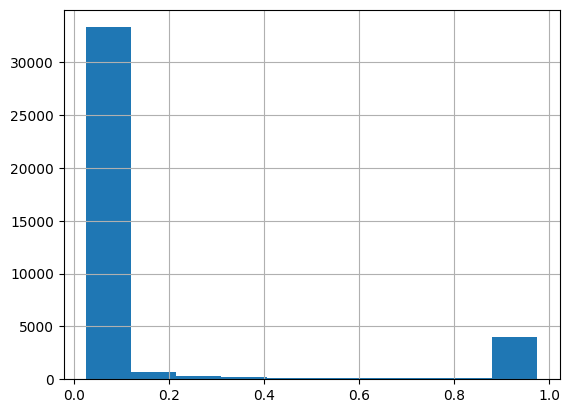

In [191]:
submission['loan_status'].hist()

In [165]:
# import joblib

# joblib.dump(preprocessor, '../models_final/preprocessor.pkl')
# joblib.dump(estimators, '../models_final/estimators.pkl')
# joblib.dump(final_model, '../models_final/final_model.pkl')